In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import  clear_output

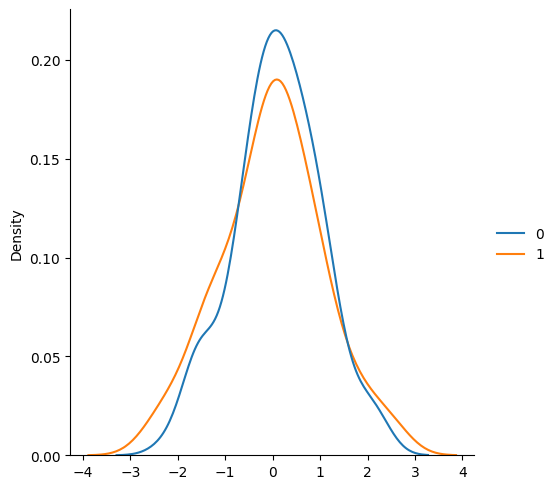

In [9]:
L = np.linspace((-5,-5), (5,5), 100)
import seaborn as sns 
L = np.random.normal(size=(100,2))
sns.displot(L,  kind="kde")

## Exemple Subset simulation 
on pose le code numérique suivant 
$$\phi(X) = X_1^2 +X_2^2$$

Avec $X \sim \mathcal{N}(0, I_2); \quad  \phi(X) \sim \chi2(2)$

In [2]:
#construction de la fonction phi 
def phi(X):
    return (np.power(X,2)).sum(axis = 0)

In [3]:
X= (np.meshgrid(np.linspace(-7,7, 100), np.linspace(-7,7, 100)))

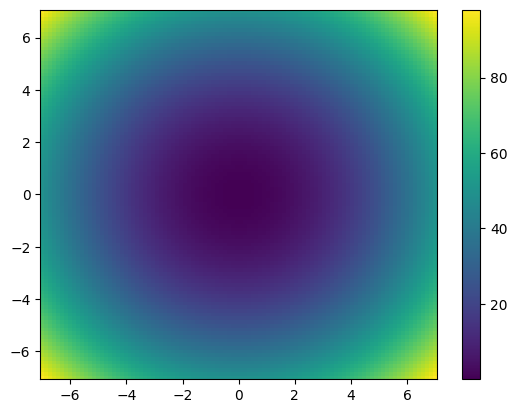

In [4]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(X[0], X[1], phi(X))
fig.colorbar(pc)

In [5]:
#vecteur aléatoire d'une normal standar 
Z = np.random.normal(size=(2, 10000))
prob_100 = np.mean(phi(Z) > 10)
print("probabilité %f avec un echantillon de 10000 " %prob_100 )

probabilité 0.005500 avec un echantillon de 10000 


In [7]:
from scipy import stats 

In [8]:
print("La probabilité théorique (approx numérique de la cdf) est %f" %(1-stats.chi2.cdf(10, 2)))

La probabilité théorique (approx numérique de la cdf) est 0.006738


<a list of 3 text.Text objects>

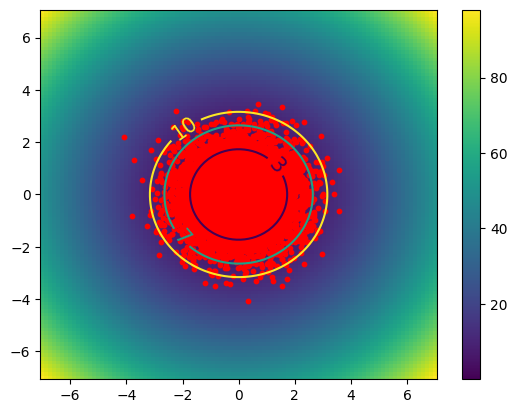

In [105]:
#visualisation si on tire selon notre distribution 
fig, ax = plt.subplots()
pc = ax.pcolormesh(X[0],X[1], phi(X))
ax.scatter(Z[0], Z[ 1], c = "red", s= 10)
cs = ax.contour(X[0],X[1], phi(X), [3,7,10])
fig.colorbar(pc)
ax.clabel(cs, cs.levels, inline=True, fontsize=15)

In [63]:
#ubset algorithm with optimized phi calculation 

def subset_simulation(sample, threshold,phi,sd, level = .1):
    dim, N = np.shape(sample)
    #list of the intermediate threshold 
    quantile = list()
    sequence = list()
    #first threshold 
    PHI = phi(sample)
    quantile.append(np.quantile(PHI, 1-level))
    k = 0
    rv = stats.multivariate_normal(mean=np.zeros(2))
    
    while quantile[k] < threshold:
        idx = np.where(PHI > quantile[k])[0] #index that statisfie.s the condition 
        #BOOTSTRAP ON THE N*LEVEL SELECTED SAMPLES 
        seed_threshold = np.random.choice(a=idx, size =N)
        sample_threshold = sample[:, seed_threshold] #N samples of the N*level samples that lie in Fk 
        phi_threshold = PHI[seed_threshold] #keep only the phi(X) interesting for Fk
        ## simulation according to mcmc 
        chain = np.zeros((dim, N)) # mcmc chain 
        ###########
        for i in range(N):
            L = [sample_threshold[:, i]] #first of a 9-length chain 
            phi_accepted = phi_threshold[i]
            for j in range(int(1/level -1)):
                candidate = L[j] + np.random.normal(scale= sd, size=2)  
                phi_candidate = phi(candidate)
                ratio = (phi_candidate> quantile[k]) * rv.pdf(candidate) / rv.pdf(L[j])
                u = np.random.uniform()
                if u < ratio :
                    L.append(candidate)
                    phi_accepted = phi_candidate
                else : 
                    L.append(L[j])
            #print(phi_accepted, phi(L[j+1]))
            phi_threshold[i] = phi_accepted
            chain[:, i ] = L[j+1] #we only keep the last mcmc simulation  
        ##### chain for the step k completed 
        sequence.append(chain) 
        PHI = phi_threshold
        quantile.append(np.quantile(PHI, 1-level )) #searching the next intermediate 
        sample = chain
        k += 1 
        
    failure = (level)**(k) * np.mean(PHI > threshold)
    return sequence, k, failure, quantile 
        
        

In [106]:
def subset_simulation(sample, threshold,phi,sd, level = .1):
    dim, N = np.shape(sample)
    #list of the intermediate threshold 
    quantile = list()
    sequence = list()
    #first threshold 
    PHI = phi(sample)
    quantile.append(np.quantile(PHI, 1-level))
    k = 0
    rv = stats.multivariate_normal(mean=np.zeros(2))
    
    while quantile[k] < threshold:
        idx = np.where(PHI > quantile[k])[0] #index that statisfie.s the condition 
        #BOOTSTRAP ON THE N*LEVEL SELECTED SAMPLES 
        random_seed = np.random.choice(a=idx, size =N)
        sample_threshold = sample[:, random_seed] #N*level samples that lie in Fk 
        phi_threshold = PHI[random_seed]
        ## simulation according to mcmc 
        chain = np.zeros((dim, N)) # mcmc chain 
        ###########
        #tensor to parallelize the process 
        L = np.zeros((int(1/level), dim, N)) 
        L[0] = sample_threshold
        phi_accepted = phi_threshold
        for j in range(int(1/level-1)):
            candidate = L[j] + np.random.normal(scale= sd, size=(2,N)) #simulation of N gaussien points candidates for each value of the Bootstraped chain
            #stock for phi(candidate) in order to calculat it only once 
            phi_candidate = phi(candidate)
            ratio =  rv.pdf(candidate.T) / rv.pdf(L[j].T) *(phi_candidate> quantile[k])
            #MAJ
            u = np.random.uniform(size= N)
            L[j+1] =  L[j] * (u >= ratio) + candidate * (u< ratio)
            phi_accepted[(u< ratio)] = phi_candidate[(u< ratio)]
        #phi_value management 
        phi_threshold = phi_accepted
        PHI = phi_threshold #new phi_values 
        
        #we only keep the last mcmc simulation
        chain = L[j+1]   
        ##### chain for the step k completed 
        sequence.append(chain) 
        quantile.append(np.quantile(PHI, 1-level )) #searching the next intermediate 
        sample = chain
        k += 1 
        
    failure = (level)**(k) * np.mean(PHI > threshold)
    return sequence, k, failure, quantile 

In [9]:
from function.SS_class import subset_simulation

In [11]:
sequence, n_event, failure, quantile, rate = subset_simulation(Z, 10, phi, 1, .2)

In [12]:
print(n_event,
quantile)

3 [3.2244364176318987, 6.420511760372315, 9.662512672546443, 12.859137003236953]


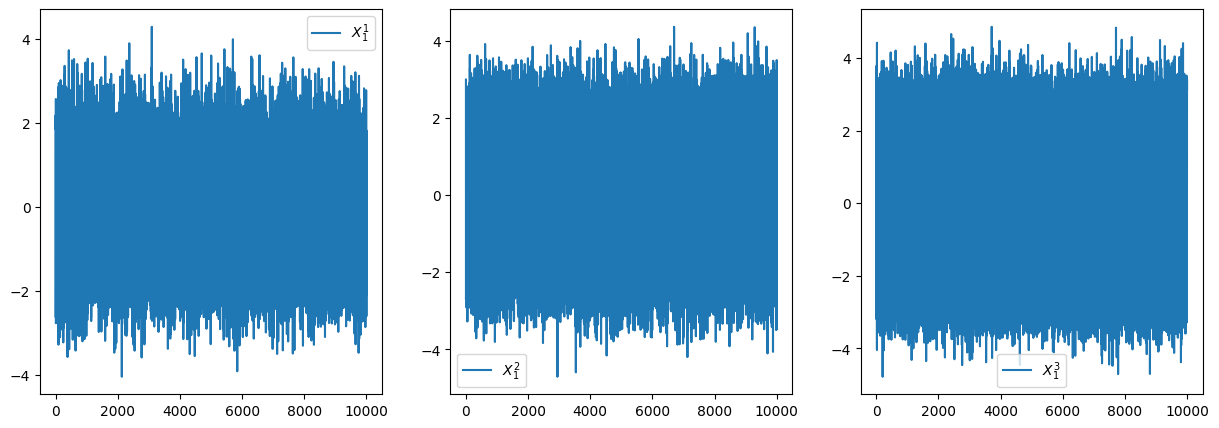

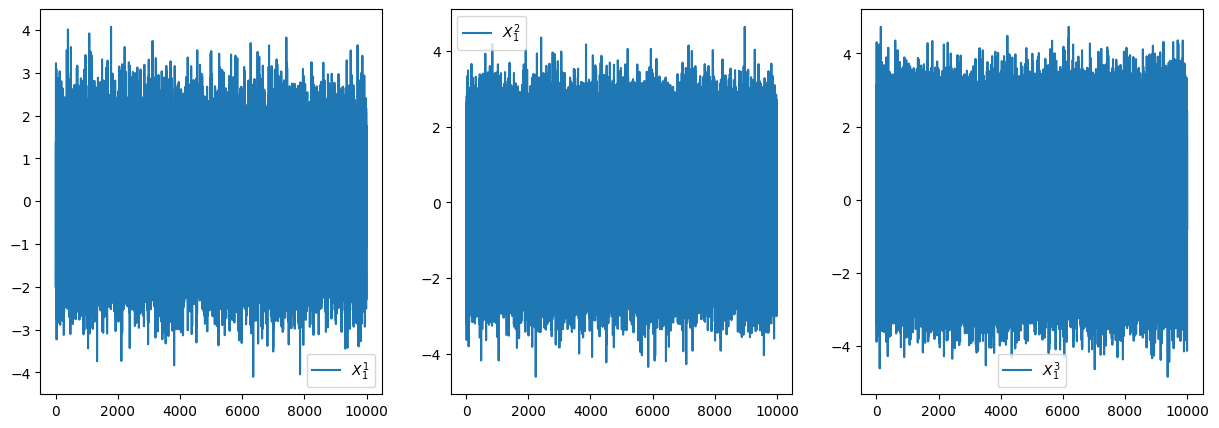

In [14]:
plt.figure(figsize= (15,5))
for i in range(len(sequence)):
    plt.subplot(1,len(sequence), i+1)
    plt.plot(sequence[i][0], label = r"$X_1^%i$"%(i+1))
    plt.legend()


plt.figure(figsize= (15,5))
for i in range(len(sequence)):
    plt.subplot(1,len(sequence), i+1)
    plt.plot(sequence[i][1], label = r"$X_1^%i$"%(i+1))
    plt.legend()

<a list of 3 text.Text objects>

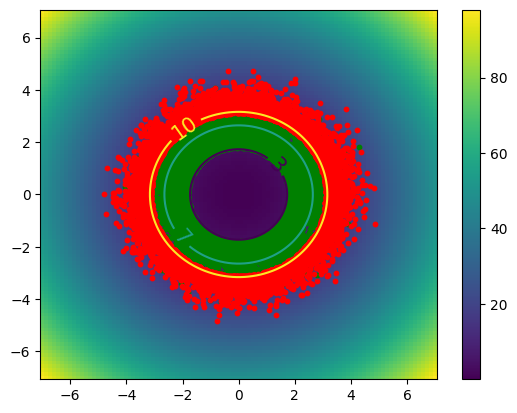

In [15]:
last_simu = sequence[-1]
second_simu = sequence[0]
fig, ax = plt.subplots()
pc = ax.pcolormesh(X[0],X[1], phi(X))
ax.scatter(second_simu[0], second_simu[ 1], c = "green", s= 10)
ax.scatter(last_simu[0], last_simu[ 1], c = "red", s= 10)
cs = ax.contour(X[0],X[1], phi(X), [3,7,10])
fig.colorbar(pc)
ax.clabel(cs, cs.levels, inline=True, fontsize=15)

In [111]:
print("La probabilité théorique  est %f" %(1-stats.chi2.cdf(10, 2)))
print("La probabilité subset_sample  est %f" %failure)

La probabilité théorique  est 0.006738
La probabilité subset_sample  est 0.006904
